In [ ]:
pip install pandas numpy nltk scikit-learn seaborn matplotlib tensorflow wordcloud

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df = pd.read_csv('comments_data.csv')  # Replace with your file path


In [3]:
df

,register_index,post_id,comment_id,author,datetime,title,url,score,comments,text,author_post_karma,tag
0,146ozvujnrwkzy,146ozvu,jnrwkzy,mackydoodles,2023-06-11 12:56:52,NaN,NaN,1.0,NaN,Just don t eat them You don t have to eat the...,11889.0,Simple Questions
1,146ozvujnsjbq4,146ozvu,jnsjbq4,shelf_actualization,2023-06-11 15:54:33,NaN,NaN,1.0,NaN,Thanks I don t 100 understand how it works y...,13327.0,Simple Questions
2,146ozvujnsqa6h,146ozvu,jnsqa6h,shelf_actualization,2023-06-11 16:43:30,NaN,NaN,1.0,NaN,Reddit is making a lot of changes including e...,13327.0,Simple Questions
3,145tbt7jnnfw9c,145tbt7,jnnfw9c,cinnamond0nut,2023-06-10 12:27:03,NaN,NaN,4.0,NaN,Corona last week flu now Resting plenty but ...,26235.0,Gym Story Saturday
4,1443xptjnj6mg1,1443xpt,jnj6mg1,shelf_actualization,2023-06-09 14:19:48,NaN,NaN,2.0,NaN,I d love to get multiple recommendations on re...,13327.0,Simple Questions
...,...,...,...,...,...,...,...,...,...,...,...,...
385982,186lygdkbayca0,186lygd,kbayca0,scubaordie,2023-11-29 19:43:40,NaN,NaN,2.0,NaN,Thanks for sharing Just joined it,NaN,NaN
385983,186lygdkb9s38z,186lygd,kb9s38z,Ringperm,2023-11-29 15:30:30,NaN,NaN,2.0,NaN,Thank you and I know all that But to be fair...,NaN,NaN
385984,186lygdkbgpjlp,186lygd,kbgpjlp,Shriakumo,2023-11-30 22:05:53,NaN,NaN,2.0,NaN,No problem I hope daily stretching can fix an...,NaN,NaN
385985,186lygdkbciwtj,186lygd,kbciwtj,siobhanmairii__,2023-11-30 01:54:07,NaN,NaN,5.0,NaN,Exactly Especially if I choose to go nude in ...,NaN,NaN


In [4]:
df.info

<bound method DataFrame.info of         register_index  post_id comment_id               author  \
0       146ozvujnrwkzy  146ozvu    jnrwkzy         mackydoodles   
1       146ozvujnsjbq4  146ozvu    jnsjbq4  shelf_actualization   
2       146ozvujnsqa6h  146ozvu    jnsqa6h  shelf_actualization   
3       145tbt7jnnfw9c  145tbt7    jnnfw9c        cinnamond0nut   
4       1443xptjnj6mg1  1443xpt    jnj6mg1  shelf_actualization   
...                ...      ...        ...                  ...   
385982  186lygdkbayca0  186lygd    kbayca0           scubaordie   
385983  186lygdkb9s38z  186lygd    kb9s38z             Ringperm   
385984  186lygdkbgpjlp  186lygd    kbgpjlp            Shriakumo   
385985  186lygdkbciwtj  186lygd    kbciwtj      siobhanmairii__   
385986  186lygdkbcmavi  186lygd    kbcmavi            vegangoku   

                   datetime title  url  score  comments  \
0       2023-06-11 12:56:52   NaN  NaN    1.0       NaN   
1       2023-06-11 15:54:33   NaN  NaN    1.0

In [5]:
df.isnull().sum()

register_index            0
post_id                   0
comment_id             1282
author                    0
datetime                  0
title                384705
url                  384705
score                     0
comments             384705
text                      4
author_post_karma    352022
tag                   52963
dtype: int64

In [6]:
# Function to clean the text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.lower()

df['cleaned_text'] = df['text'].apply(lambda x: clean_text(str(x)))
df.dropna(subset=['cleaned_text'], inplace=True)  # Drop rows with missing text

In [7]:
sia = SentimentIntensityAnalyzer()

# Assign sentiment labels using VADER
df['sentiment_score'] = df['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

# Check sentiment distribution
df['sentiment'].value_counts()


sentiment
positive    211400
negative     90728
neutral      83859
Name: count, dtype: int64

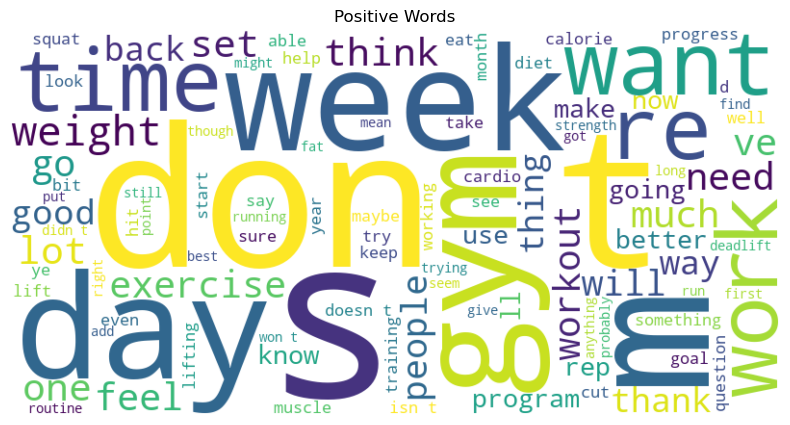

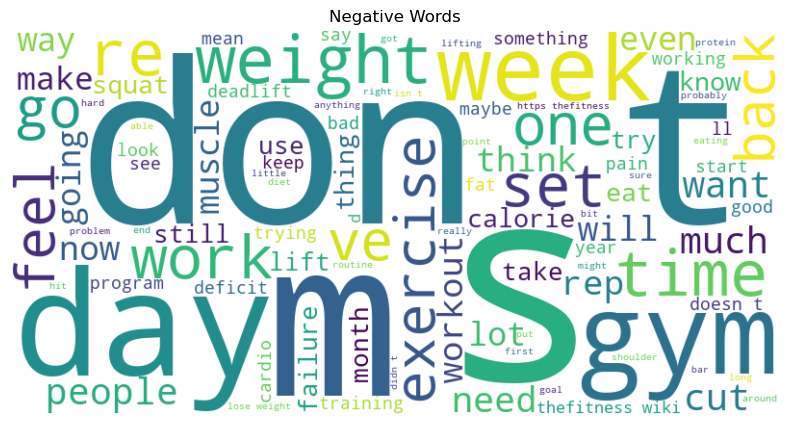

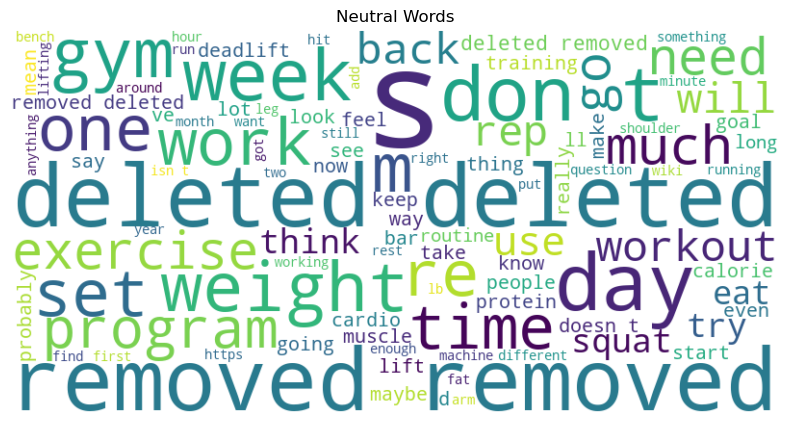

In [16]:
# Function to generate word cloud
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# WordCloud for positive, negative, and neutral texts
generate_wordcloud(df[df['sentiment'] == 'positive']['cleaned_text'], 'Positive Words')
generate_wordcloud(df[df['sentiment'] == 'negative']['cleaned_text'], 'Negative Words')
generate_wordcloud(df[df['sentiment'] == 'neutral']['cleaned_text'], 'Neutral Words')

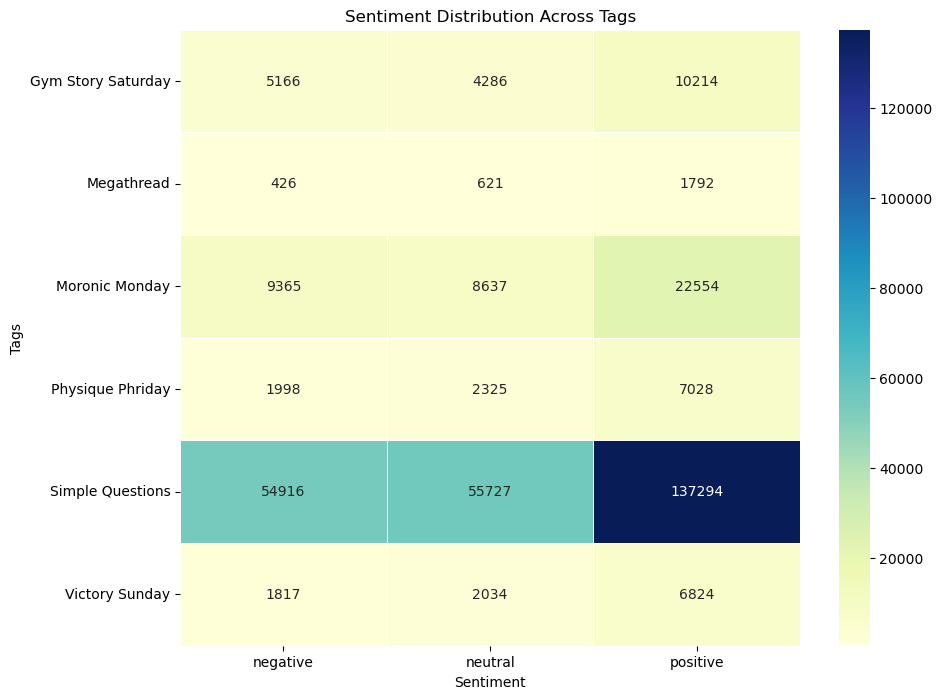

In [20]:
def plot_sentiment_heatmap(df):
    heatmap_data = pd.crosstab(df['tag'], df['sentiment'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5)
    plt.title('Sentiment Distribution Across Tags')
    plt.xlabel('Sentiment')
    plt.ylabel('Tags')
    plt.show()

plot_sentiment_heatmap(df)

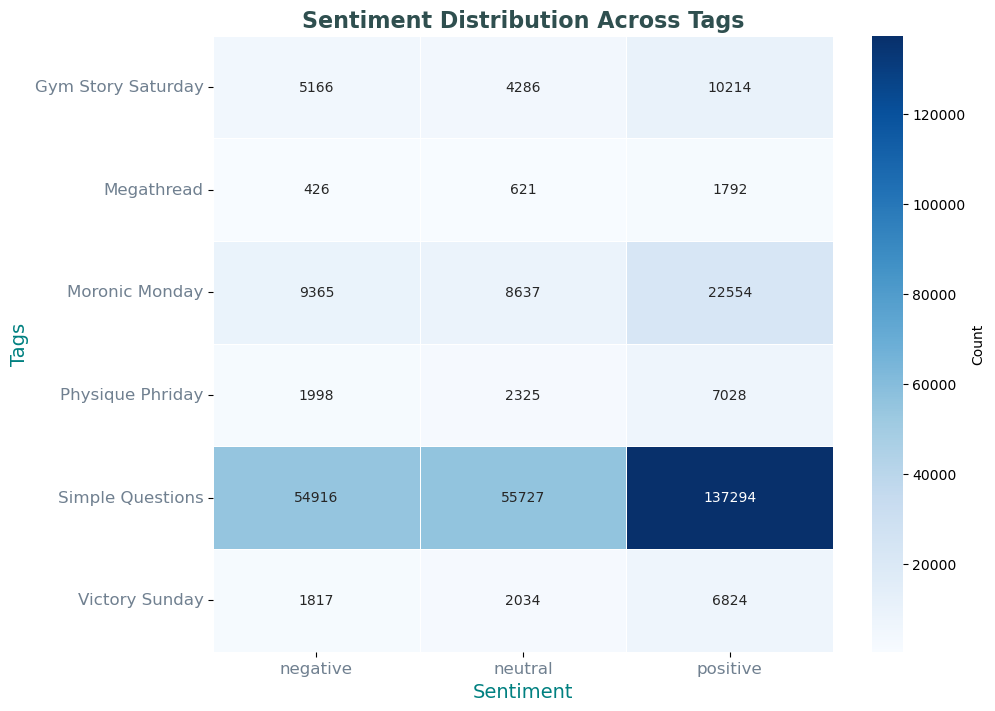

In [36]:
def plot_sentiment_heatmap(df, save_as_image=True, filename="sentiment_heatmap.png"):
    # Create the heatmap data
    heatmap_data = pd.crosstab(df['tag'], df['sentiment'])
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    
    # Using a light color palette: "Blues" (soft shades of blue)
    sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d', linewidths=0.5, 
                cbar_kws={'label': 'Count'}, linecolor='white')

    # Add title and labels with a lighter color scheme
    plt.title('Sentiment Distribution Across Tags', fontsize=16, fontweight='bold', color='darkslategray')
    plt.xlabel('Sentiment', fontsize=14, color='teal')
    plt.ylabel('Tags', fontsize=14, color='teal')

    # Adjust tick labels to be softer and visible
    plt.xticks(fontsize=12, color='slategray')
    plt.yticks(fontsize=12, color='slategray')

    # Add a grid for better readability (optional)
    plt.grid(False)
    
    # Save the plot as an image if requested
    if save_as_image:
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    
    # Show the plot
    plt.show()

# Example usage
plot_sentiment_heatmap(df, save_as_image=True, filename="light_sentiment_heatmap.png")

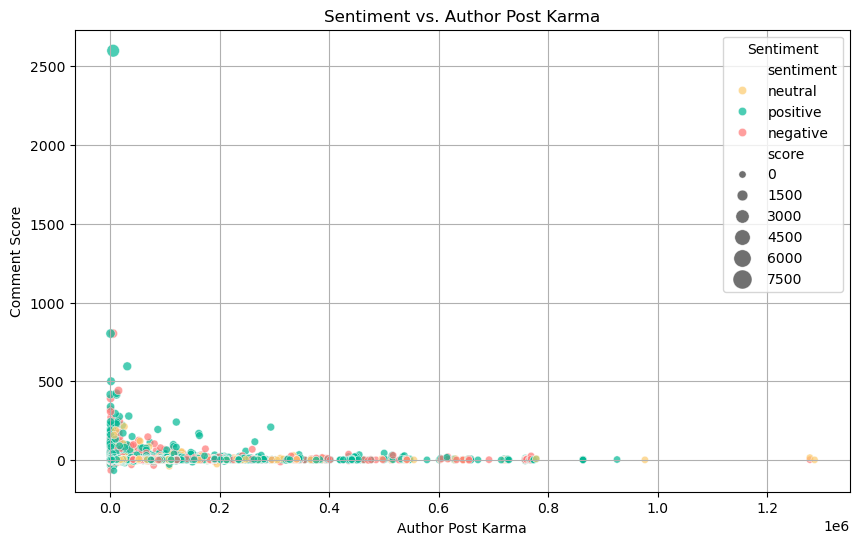

C:\Users\Admin\AppData\Local\Temp\ipykernel_10056\1658719897.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='sentiment', y='comment_length', data=df, palette='Set2')


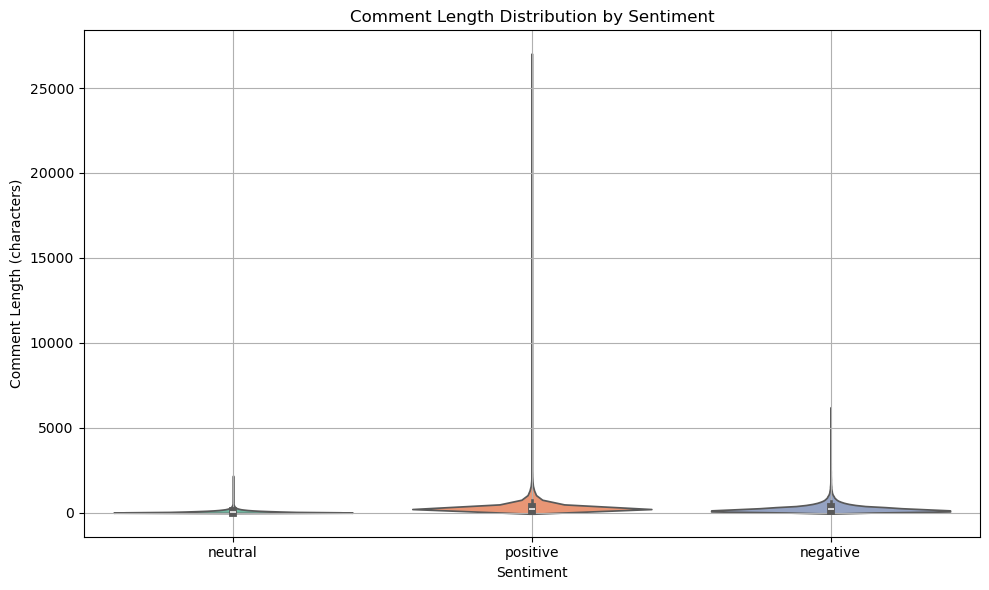

In [26]:
def plot_violin_sentiment(df):
    df['comment_length'] = df['cleaned_text'].apply(len)  # Calculate comment length

    plt.figure(figsize=(10, 6))
    sns.violinplot(x='sentiment', y='comment_length', data=df, palette='Set2')

    plt.title('Comment Length Distribution by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Comment Length (characters)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_violin_sentiment(df)

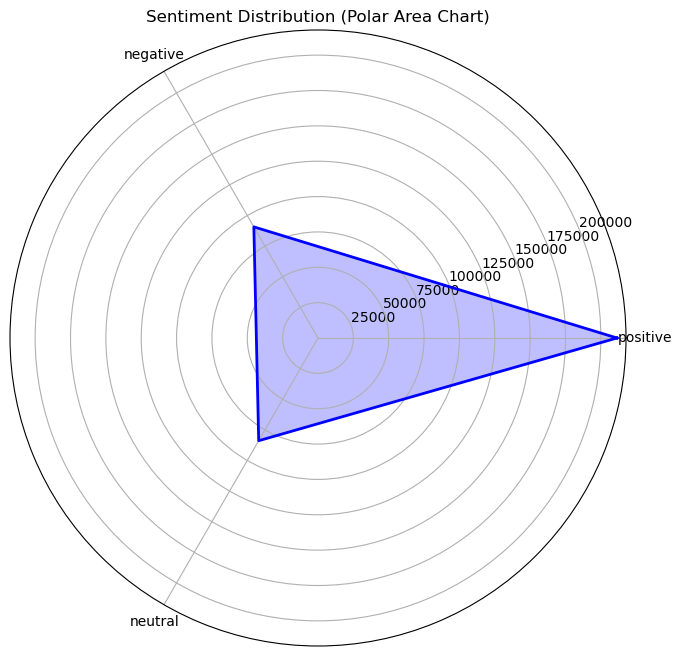

In [30]:
def plot_polar_area_chart(df):
    sentiment_counts = df['sentiment'].value_counts()

    categories = sentiment_counts.index
    values = sentiment_counts.values

    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    plt.title('Sentiment Distribution (Polar Area Chart)')
    plt.show()

plot_polar_area_chart(df)


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['sentiment']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X

In [ ]:
y

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Model evaluation
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_text'])

X_seq = tokenizer.texts_to_sequences(df['cleaned_text'])
X_pad = pad_sequences(X_seq, maxlen=200)

# Convert sentiments to categorical values
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_categorical = to_categorical(df['sentiment'].map(sentiment_map))

# Split dataset for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, y_categorical, test_size=0.3, random_state=42)